# What to expect from AutoML software
Automated machine learning (AutoML) takes a higher-level approach to machine learning than most practitioners are used to, so we've gathered a handful of guidelines on what to expect when running AutoML software such as TPOT.

#### AUTOML ALGORITHMS AREN'T INTENDED TO RUN FOR ONLY A FEW MINUTES
Of course, you can run TPOT for only a few minutes, and it will find a reasonably good pipeline for your dataset. However, if you don't run TPOT for long enough, it may not find the best possible pipeline for your dataset. It may not even find any suitable pipeline at all, in which case a RuntimeError('A pipeline has not yet been optimized. Please call fit() first.') will be raised. Often it is worthwhile to run multiple instances of TPOT in parallel for a long time (hours to days) to allow TPOT to thoroughly search the pipeline space for your dataset.

#### AUTOML ALGORITHMS CAN TAKE A LONG TIME TO FINISH THEIR SEARCH
AutoML algorithms aren't as simple as fitting one model on the dataset; they consider multiple machine learning algorithms (random forests, linear models, SVMs, etc.) in a pipeline with multiple preprocessing steps (missing value imputation, scaling, PCA, feature selection, etc.), the hyperparameters for all of the models and preprocessing steps, and multiple ways to ensemble or stack the algorithms within the pipeline.

As such, TPOT will take a while to run on larger datasets, but it's important to realize why. With the default TPOT settings (100 generations with 100 population size), TPOT will evaluate 10,000 pipeline configurations before finishing. To put this number into context, think about a grid search of 10,000 hyperparameter combinations for a machine learning algorithm and how long that grid search will take. That is 10,000 model configurations to evaluate with 10-fold cross-validation, which means that roughly 100,000 models are fit and evaluated on the training data in one grid search. That's a time-consuming procedure, even for simpler models like decision trees.

Typical TPOT runs will take hours to days to finish (unless it's a small dataset), but you can always interrupt the run partway through and see the best results so far. TPOT also provides a warm_start and a periodic_checkpoint_folder parameter that lets you restart a TPOT run from where it left off.

#### AUTOML ALGORITHMS CAN RECOMMEND DIFFERENT SOLUTIONS FOR THE SAME DATASET
If you're working with a reasonably complex dataset or run TPOT for a short amount of time, different TPOT runs may result in different pipeline recommendations. TPOT's optimization algorithm is stochastic, which means that it uses randomness (in part) to search the possible pipeline space. When two TPOT runs recommend different pipelines, this means that the TPOT runs didn't converge due to lack of time or that multiple pipelines perform more-or-less the same on your dataset.

This is actually an advantage over fixed grid search techniques: TPOT is meant to be an assistant that gives you ideas on how to solve a particular machine learning problem by exploring pipeline configurations that you might have never considered, then leaves the fine-tuning to more constrained parameter tuning techniques such as grid search or bayesian optimization.

# TPOT with code

We've designed the TPOT interface to be as similar as possible to scikit-learn.

TPOT can be imported just like any regular Python module. To import TPOT, type:

In [1]:
import tpot
from tpot import TPOTClassifier

then create an instance of TPOT as follows:

In [2]:
classification_optimizer = TPOTClassifier()

It's also possible to use TPOT for regression problems with the TPOTRegressor class. Other than the class name, a TPOTRegressor is used the same way as a TPOTClassifier. You can read more about the TPOTClassifier and TPOTRegressor classes in the API documentation.

In [3]:
from tpot import TPOTRegressor
regression_optimizer = TPOTRegressor()

Fitting a TPOT model works exactly like any other sklearn estimator. Some example code with custom TPOT parameters might look like:

In [4]:
import sklearn
import sklearn.datasets
import sklearn.metrics
import tpot

classification_optimizer = TPOTClassifier(search_space="linear-light", max_time_mins=30/60, n_jobs=30, cv=5)

X, y = sklearn.datasets.load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=1, test_size=0.2)

classification_optimizer.fit(X_train, y_train)

auroc_score = sklearn.metrics.roc_auc_score(y_test, classification_optimizer.predict_proba(X_test)[:,1])
print("auroc_score: ", auroc_score)

Generation: : 4it [00:30,  7.62s/it]


auroc_score:  0.9960317460317459


## Scorers, Objective Functions, and multi objective optimization.

There are two ways of passing objectives into TPOT. 

1. `scorers`: Scorers are functions that have the signature (estimator, X_test, y_test) and take in estimators that are expected to be fitted to training data. These can be produced with the [sklearn.metrics.make_scorer](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) function. This function is used to evaluate the test folds during cross validation (defined in the `cv` parameter). These are passed into TPOT via the scorers parameter. This can take in the scorer itself or the string corresponding to a scoring function ([as listed here](https://scikit-learn.org/stable/modules/model_evaluation.html)). TPOT also supports passing in a list of several scorers for multi-objective optimization. For each fold of CV, TPOT only fits the estimator once, then evaluates all provided scorers in a loop.

2. `other_objective_functions` : Other objective functions in TPOT have the signature (estimator) and returns a float or list of floats. These get passed a single unfitted estimator once, outside of cross validation. The user may choose to fit the pipeline within this objective function as well.



Each scorer and objective function must be accompanied by a list of weights corresponding to the list of objectives, these are `scorers_weights` and `other_objective_function_weights`, respectively. By default, TPOT maximizes objective functions (this can be changed by `bigger_is_better=False`). Positive weights means that TPOT will seek to maximize that objective, and negative weights correspond to minimization. For most selectors (and the default), only the sign matters. The scale of the weight may matter if using a custom selection function for the optimization algorithm. A zero weight means that the score will not have an impact on the selection algorithm.

Here is an example of using two scorers

    scorers=['roc_auc_ovr',tpot.objectives.complexity_scorer],
    scorers_weights=[1,-1],


Here is an example with a scorer and a secondary objective function

    scorers=['roc_auc_ovr'],
    scorers_weights=[1],
    other_objective_functions=[tpot.objectives.number_of_leaves_objective],
    other_objective_functions_weights=[-1],


TPOT will always automatically name the scorers based on the function name for the columns in the final results dataframe. TPOT will use the function name as the column name for `other_objective_functions`. However, if you would like to specify custom column names, you can set the `objective_function_names` to be a list of names (str) for each value returned by the function in `other_objective_functions`. This can be useful if your additional functions return more than one value per function.

It is possible to have either the scorer or other_objective_function to return multiple values. In that case, just make sure that the `scorers_weights` and `other_objective_function_weights` are the same length as the number of returned scores.


TPOT comes with a few additional built in objective functions you can use. The first table are objectives applied to fitted pipelines, and thus are passee into the `scorers` parameter. The second table are objective functions for the `other_objective_functions` param.

Scorers:
| Function     | Description      |
| :---        |    :----:   |
| tpot.objectives.complexity_scorer | Estimates the number of learned parameters across all classifiers and regressors in the pipelines. Additionally, currently transformers add 1 point and selectors add 0 points (since they don't affect the complexity of the "final" predictive pipeline.) |

Other Objective Functions.

| Function     | Description      |
| :---        |    :----:   |
| tpot.objectives.average_path_length | Computes the average shortest path from all nodes to the root/final estimator (only supported for GraphPipeline) |
| tpot.objectives.number_of_leaves_objective | Calculates the number of leaves (input nodes) in a GraphPipeline |
| tpot.objectives.number_of_nodes_objective | Calculates the number of nodes in a pipeline (whether it is an scikit-learn Pipeline, GraphPipeline, Feature Union, or the previous nested within each other) |

## Measuring Model Complexity

When running TPOT, including a secondary objective that measures model complexity can sometimes be beneficial. More complex models can yield higher performance, but this comes at the cost of interpretability. Simpler models may be more interpretable but often have lower predictive performance. Sometimes, however, vast increases in complexity only marginally improve predictive performance. There may be other simpler and more interpretable pipelines with marginal performance decreases that could be acceptable for the increased interpretability. However, these pipelines are often missed when optimizing purely for performance. By including both performance and complexity as objective functions, TPOT will attempt to optimize the best pipeline for all complexity levels simultaneously. After optimization, the user will be able to see the complexity vs performance tradeoff and decide which pipeline best suits their needs. 

Two methods of measuring complexity to consider would be `tpot.objectives.number_of_nodes_objective` or `tpot.objectives.complexity_scorer`. The number of nodes objective simply calculates the number of steps within a pipeline. This is a simple metric, however it does not differentiate between the complexity of different model types. For example, a simple LogisticRegression counts the same as the much more complex XGBoost. The complexity scorer tries to estimate the number of learned parameters included in the classifiers and regressors of the pipeline. It is challenging and potentially subjective how to exactly quantify and compare complexity between different classes of models. However, this function provides a reasonable heuristic for the evolutionary algorithm that at least separates out qualitatively more or less complex algorithms from one another. While it may be hard to compare the relative complexities of LogisticRegression and XGBoost exactly, for example, both will always be on opposite ends of the complexity values returned by this function. This allows for pareto fronts with LogisticRegression on one side, and XGBoost on the other.

An example of this analysis is demonstrated in a following section.

## Built In Configurations
TPOT can be used to optimize hyperparameters, select models, and optimize pipelines of models including determining the sequence of steps. **Tutorial 2** goes into more detail on how to customize search spaces with custom hyperparameter ranges, model types, and possible pipeline configurations. TPOT also comes with a handful of default operators and parameter configurations that we believe work well for optimizing machine learning pipelines. Below is a list of the current built-in configurations that come with TPOT. These can be passed in as strings to the `search space` parameter of any of the TPOT estimators.

| String     | Description      |
| :---        |    :----:   |
| linear  | A linear pipeline with the structure of "Selector->(transformers+Passthrough)->(classifiers/regressors+Passthrough)->final classifier/regressor." For both the transformer and inner estimator layers, TPOT may choose one or more transformers/classifiers, or it may choose none. The inner classifier/regressor layer is optional. |
| linear-light | Same search space as linear, but without the inner classifier/regressor layer and with a reduced set of faster running estimators. |
| graph | TPOT will optimize a pipeline in the shape of a directed acyclic graph. The nodes of the graph can include selectors, scalers, transformers, or classifiers/regressors (inner classifiers/regressors can optionally be not included). This will return a custom GraphPipeline rather than an sklearn Pipeline. More details in Tutorial 6. |
| graph-light | Same as graph search space, but without the inner classifier/regressors and with a reduced set of faster running estimators. |
| mdr |TPOT will search over a series of feature selectors and Multifactor Dimensionality Reduction models to find a series of operators that maximize prediction accuracy. The TPOT MDR configuration is specialized for genome-wide association studies (GWAS), and is described in detail online here.

Note that TPOT MDR may be slow to run because the feature selection routines are computationally expensive, especially on large datasets. |

The `linear` and `graph` configurations by default allow for additional stacked classifiers/regressors within the pipeline in addition to the final classifier/regressor. If you would like to disable this, you can manually get the search space without inner classifier/regressors through the function `tpot.config.template_search_spaces.get_template_search_spaces` with `inner_predictios=False`. You can pass the resulting search space into the `search space` param. 

In [5]:
import tpot
from tpot.search_spaces.pipelines import SequentialPipeline
from tpot.config import get_search_space

stc_search_space = SequentialPipeline([
    get_search_space("selectors"),
    get_search_space("all_transformers"),
    get_search_space("classifiers"),
])

est = tpot.TPOTEstimator(
    search_space = stc_search_space,
    scorers=["roc_auc_ovr", tpot.objectives.complexity_scorer],
    scorers_weights=[1.0, -1.0],
    classification = True,
    cv = 5,
    max_eval_time_mins = 10,
    early_stop = 2,
    verbose = 2,
    n_jobs=4,
)


Using a built in method

In [6]:
est = tpot.TPOTEstimator(
    search_space = "linear",
    scorers=["roc_auc_ovr", tpot.objectives.complexity_scorer],
    scorers_weights=[1.0, -1.0],
    classification = True,
    cv = 5,
    max_eval_time_mins = 10,
    early_stop = 2,
    verbose = 2,
    n_jobs=4,
)

The specific hyperparameter ranges used by TPOT can be found in files in the tpot/config folder. The template search spaces listed above are defined in tpot/config/template_search_spaces.py. Search spaces for individual models can be acquired in the tpot/config/get_configspace.py file (`tpot.config.get_search_space`). More details on customizing search spaces can be found in Tutorial 2.


    `tpot.config.template_search_spaces.get_template_search_spaces`
    Returns a search space which can be optimized by TPOT.

    Parameters
    ----------
    search_space: str or SearchSpace
        The default search space to use. If a string, it should be one of the following:
            - 'linear': A search space for linear pipelines
            - 'linear-light': A search space for linear pipelines with a smaller, faster search space
            - 'graph': A search space for graph pipelines
            - 'graph-light': A search space for graph pipelines with a smaller, faster search space
            - 'mdr': A search space for MDR pipelines
        If a SearchSpace object, it should be a valid search space object for TPOT.
    
    classification: bool, default=True
        Whether the problem is a classification problem or a regression problem.

    inner_predictors: bool, default=None
        Whether to include additional classifiers/regressors before the final classifier/regressor (allowing for ensembles). 
        Defaults to False for 'linear-light' and 'graph-light' search spaces, and True otherwise. (Not used for 'mdr' search space)
    
    cross_val_predict_cv: int, default=None
        The number of folds to use for cross_val_predict. 
        Defaults to 0 for 'linear-light' and 'graph-light' search spaces, and 5 otherwise. (Not used for 'mdr' search space)

    get_search_space_params: dict
        Additional parameters to pass to the get_search_space function.

### cross_val_predict_cv

Additionally, utilizing `cross_val_predict_cv` may increase performance when training models with inner classifiers/regressors. If this parameter is set, during model training any classifiers or regressors that is not the final predictor will use `sklearn.model_selection.cross_val_predict` to pass out of sample predictions into the following steps of the model. The model will still be fit to the full data which will be used for predictions after training. Training downstream models on out of sample predictions can often prevent overfitting and increase performance. The reason is that this gives downstream models a estimate of how upstream models compare on unseen data. Otherwise, if an upsteam model heavily overfits the data, downsteam models may simply learn to blindly trust the seemingly well-predicting model, propagating the over-fitting through to the end result.

The downside is that cross_val_predict_cv is significantly more computationally demanding, and may not be necessary for your given dataset. 


In [7]:
linear_with_cross_val_predict_sp = tpot.config.template_search_spaces.get_template_search_spaces(search_space="linear", classification=True, inner_predictors=True, cross_val_predict_cv=5)
classification_optimizer = TPOTClassifier(search_space=linear_with_cross_val_predict_sp, max_time_mins=30/60, n_jobs=30, cv=5)

## Terminating Optimization (Early Stopping)

Note that we use a short time duration for a quick example, but in practice, you may need to run TPOT for a longer duration. By default, TPOT sets a time limit of 1 hour with a max limit of 5 minutes per pipeline. In practice, you may want to increase these values.

There are three methods of terminating a TPOT run and ending the optimization process. TPOT will terminate as soon as one of the conditions is met.
* `max_time_mins` : (Default, 60 minutes) After this many minutes, TPOT will terminate and return the best pipeline it found so far.
* `early_stop` : The number of generations without seeing an improvement in performance, after which TPOT terminates. Generally, a value of around 5 to 20 is sufficient to be reasonably sure that performance has converged.
* `generations`: The total number of generations of the evolutionary algorithm to run.

By default, TPOT will run until the time limit is up, with no generation or early stop limits.

## Best Practices and tips:

* When running tpot from an .py script, it is important to protect code with `if __name__=="__main__":` . This is because of how TPOT handles parallelization with Python and Dask.

In [8]:
from dask.distributed import Client, LocalCluster
import tpot
import sklearn
import sklearn.datasets
import numpy as np

if __name__=="__main__":
    scorer = sklearn.metrics.get_scorer('roc_auc_ovo')
    X, y = sklearn.datasets.load_digits(return_X_y=True)
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.75, test_size=0.25)


    est = tpot.TPOTClassifier(n_jobs=4, max_time_mins=3, verbose=2, early_stop=3)
    est.fit(X_train, y_train)


    print(scorer(est, X_test, y_test))

Generation: : 2it [03:01, 90.79s/it]


0.9992949729502254


# Example analysis and the Estimator class 

Here we use a toy example dataset included in scikit-learn. We will use the `light` configuration and the `complexity_scorer` to estimate complexity.

Note, for this toy example, we set a relatively short run time. In practice, we would recommend running TPOT for a longer duration with an `early_stop` value of around 5 to 20 (more details below).

In [9]:
from dask.distributed import Client, LocalCluster
import tpot
import sklearn
import sklearn.datasets
import numpy as np

import tpot.objectives


scorer = sklearn.metrics.get_scorer('roc_auc_ovr')

X, y = sklearn.datasets.load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.75, test_size=0.25)


est = tpot.TPOTClassifier(
    scorers=[scorer, tpot.objectives.complexity_scorer],
    scorers_weights=[1.0, -1.0],

    search_space="linear",
    n_jobs=4, 
    max_time_mins=60, 
    max_eval_time_mins=10,
    early_stop=2,
    verbose=2,)
est.fit(X_train, y_train)

print(scorer(est, X_test, y_test))

Generation: : 4it [01:38, 24.53s/it]


0.9955242966751918


You can access the best pipeline selected by TPOT with the `fitted_pipeline_` attribute. This is the pipeline with the highest cross validation score (on the first scorer, or first objective function if no scorer is provided.)

In [10]:
best_pipeline = est.fitted_pipeline_
best_pipeline

Pipeline(steps=[('passthrough', Passthrough()),
                ('selectfwe', SelectFwe(alpha=0.0078121592703)),
                ('featureunion-1',
                 FeatureUnion(transformer_list=[('featureunion',
                                                 FeatureUnion(transformer_list=[('zerocount',
                                                                                 ZeroCount())])),
                                                ('passthrough',
                                                 Passthrough())])),
                ('featureunion-2',
                 FeatureUnion(transformer_list=[('skiptransformer',
                                                 SkipTransformer()),
                                                ('passthrough',
                                                 Passthrough())])),
                ('adaboostclassifier',
                 AdaBoostClassifier(learning_rate=0.8192422162344,
                                    n_estimators=446))])

In [11]:
best_pipeline.predict(X_test)

array([1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1])

## Saving the Pipeline

We recommend using dill or pickle to save the instance of the fitted_pipeline_. Note that we do not recommend pickling the TPOT object itself.

In [12]:
import dill as pickle
with open("best_pipeline.pkl", "wb") as f:
    pickle.dump(best_pipeline, f)

#load the pipeline
import dill as pickle
with open("best_pipeline.pkl", "rb") as f:
    my_loaded_best_pipeline = pickle.load(f)

## The evaluated_individuals Dataframe - Further analysis of results

The `evaluated_individuals` attribute of the tpot estimator object is a Pandas Dataframe containing information about a run. Each row corresponds to an individual pipeline explored by tpot. The dataframe contains the following columns:

| Column     | Description      |
| :---        |    :----:   |
| \<n objective function columns\>     |  The first set of columns will correspond to each objective function. These can either be automatically named by TPOT, or passed in by the user.    |
| Parents  | This contains a tuple that contains the indexes of the 'parents' of the current pipeline. For example, (29, 42) means that the pipelines in indexes 29 and 42 were utilized to generate that pipeline. |
| Variation_Function | The function applied to the parents to generate the new pipeline |
| Individual | The individual class that represents a specific pipeline and hyperparameter configuration. This class also contains functions for mutation and crossover. To get the sklearn estimator/pipeline object from the individual you can call the `export_pipeline()` function. (as in, `pipe = ind.export_pipeline()`) |
| Generation | The generation where the individual was created. (Note that the higher performing pipelines from previous generations may still be present in the current "population" of a given generation if selected.) |
| Submitted Timestamp | Timestamp, in seconds, at which the pipeline was sent to be evaluated. This is the output of time.time(), which is "Return the time in seconds since the epoch as a floating-point number. " |
| Completed Timestamp | Timestamp at which the pipeline evaluation completed in the same units as Submitted Timestamp |
| Pareto_Front	 | If you have multiple parameters, this column is True if the pipeline performance fall on the pareto front line. This is the set of pipelines with scores that are strictly better than pipelines not on the line, but not strictly better than one another. |
| Instance | This contains the unfitted pipeline evaluated for this row. (This is the pipeline returned by calling the export_pipeline() function of the individual class) |


In [13]:
#get the score/objective column names generated by TPOT
est.objective_names

['roc_auc_score', 'complexity_scorer']

In [13]:
df = est.evaluated_individuals
df

,roc_auc_score,complexity_scorer,Parents,Variation_Function,Individual,Generation,Submitted Timestamp,Completed Timestamp,Eval Error,Pareto_Front,Instance
0,NaN,NaN,NaN,NaN,<tpot.search_spaces.pipelines.sequential.Seque...,0.0,1.734975e+09,1.734975e+09,INVALID,NaN,"(MinMaxScaler(), SelectFwe(alpha=0.03084215664..."
1,NaN,NaN,NaN,NaN,<tpot.search_spaces.pipelines.sequential.Seque...,0.0,1.734975e+09,1.734975e+09,INVALID,NaN,"(MinMaxScaler(), SelectFwe(alpha=0.03260916505..."
2,NaN,NaN,NaN,NaN,<tpot.search_spaces.pipelines.sequential.Seque...,0.0,1.734975e+09,1.734975e+09,INVALID,NaN,"(Normalizer(norm='l1'), VarianceThreshold(thre..."
3,0.991827,10703.0,NaN,NaN,<tpot.search_spaces.pipelines.sequential.Seque...,0.0,1.734975e+09,1.734975e+09,None,NaN,"(MaxAbsScaler(), Passthrough(), FeatureUnion(t..."
4,NaN,NaN,NaN,NaN,<tpot.search_spaces.pipelines.sequential.Seque...,0.0,1.734975e+09,1.734975e+09,INVALID,NaN,"(StandardScaler(), VarianceThreshold(threshold..."
...,...,...,...,...,...,...,...,...,...,...,...
245,0.990522,9.0,"(155, 155)",ind_mutate,<tpot.search_spaces.pipelines.sequential.Seque...,4.0,1.734976e+09,1.734976e+09,None,1.0,"(StandardScaler(), SelectPercentile(percentile..."
246,0.949947,6.0,"(87, 17)",ind_crossover,<tpot.search_spaces.pipelines.sequential.Seque...,4.0,1.734976e+09,1.734976e+09,None,NaN,"(MinMaxScaler(), VarianceThreshold(threshold=0..."
247,NaN,NaN,"(14, 14)",ind_mutate,<tpot.search_spaces.pipelines.sequential.Seque...,4.0,1.734976e+09,1.734976e+09,INVALID,NaN,"(StandardScaler(), SelectFwe(alpha=0.002516980..."
248,0.988965,18.0,"(199, 116)",ind_crossover,<tpot.search_spaces.pipelines.sequential.Seque...,4.0,1.734976e+09,1.734976e+09,None,NaN,"(MaxAbsScaler(), SelectFwe(alpha=0.00057053364..."


## Let's plot the performances of the different pipelines, including the Pareto front

Plotting the performance of multiple objectives in a scatterplot is a helpful way to visualize the tradeoff between model complexity and predictive performance. This is best visualized when plotting the Pareto front pipelines, which present the best-performing pipeline along the spectrum of complexity. Generally, higher complexity models may yield higher performance but be more difficult to interpret. 

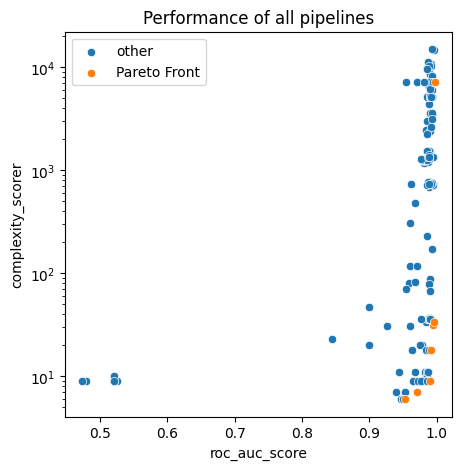

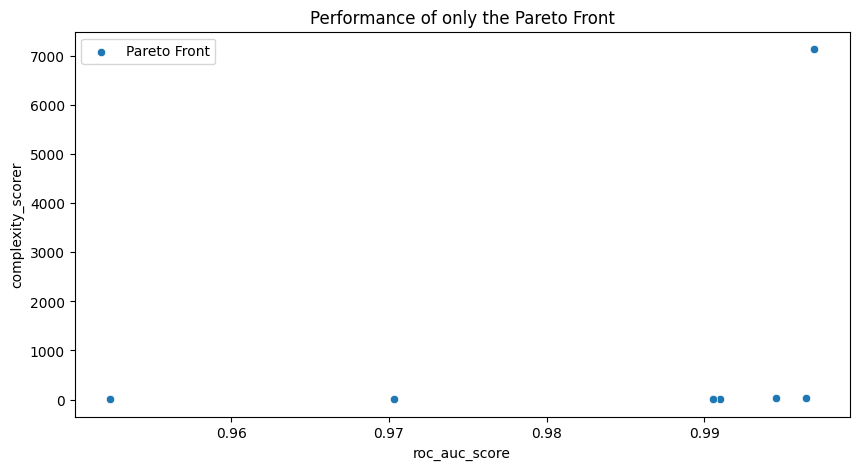

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
#replace nans in pareto front with 0
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(df[df['Pareto_Front']!=1], x='roc_auc_score', y='complexity_scorer', label='other', ax=ax)
sns.scatterplot(df[df['Pareto_Front']==1], x='roc_auc_score', y='complexity_scorer', label='Pareto Front', ax=ax)
ax.title.set_text('Performance of all pipelines')
#log scale y
ax.set_yscale('log')
plt.show()

#replace nans in pareto front with 0
fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(df[df['Pareto_Front']==1], x='roc_auc_score', y='complexity_scorer', label='Pareto Front', ax=ax)
ax.title.set_text('Performance of only the Pareto Front')
#log scale y
# ax.set_yscale('log')
plt.show()

In [15]:
#plot only the pareto front pipelines
sorted_pareto_front = df[df['Pareto_Front']==1].sort_values('roc_auc_score', ascending=False)
sorted_pareto_front

,roc_auc_score,complexity_scorer,Parents,Variation_Function,Individual,Generation,Submitted Timestamp,Completed Timestamp,Eval Error,Pareto_Front,Instance
226,0.996974,7141.0,"(175, 167)","ind_mutate , ind_mutate , ind_crossover",<tpot.search_spaces.pipelines.sequential.Seque...,4.0,1.734976e+09,1.734976e+09,None,1.0,"(Passthrough(), SelectFwe(alpha=0.007812159270..."
239,0.996435,33.9,"(168, 168)",ind_mutate,<tpot.search_spaces.pipelines.sequential.Seque...,4.0,1.734976e+09,1.734976e+09,None,1.0,"(MaxAbsScaler(), SelectFwe(alpha=0.00199526767..."
53,0.994525,31.3,"(44, 44)",ind_mutate,<tpot.search_spaces.pipelines.sequential.Seque...,1.0,1.734975e+09,1.734975e+09,None,1.0,"(MaxAbsScaler(), VarianceThreshold(threshold=0..."
181,0.991000,18.0,"(68, 85)",ind_crossover,<tpot.search_spaces.pipelines.sequential.Seque...,3.0,1.734975e+09,1.734975e+09,None,1.0,"(RobustScaler(quantile_range=(0.0518636631319,..."
245,0.990522,9.0,"(155, 155)",ind_mutate,<tpot.search_spaces.pipelines.sequential.Seque...,4.0,1.734976e+09,1.734976e+09,None,1.0,"(StandardScaler(), SelectPercentile(percentile..."
237,0.970314,7.0,"(76, 76)",ind_mutate,<tpot.search_spaces.pipelines.sequential.Seque...,4.0,1.734976e+09,1.734976e+09,None,1.0,"(MaxAbsScaler(), VarianceThreshold(threshold=0..."
144,0.952305,6.0,"(87, 87)",ind_mutate,<tpot.search_spaces.pipelines.sequential.Seque...,2.0,1.734975e+09,1.734975e+09,None,1.0,"(StandardScaler(), VarianceThreshold(threshold..."


In some cases, you may want to select a slightly lower performing pipeline that is signficantly less complex.

In [16]:
#access the best performing pipeline with the lowest complexity

best_pipeline_lowest_complexity = sorted_pareto_front.iloc[-1]['Instance']
best_pipeline_lowest_complexity

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('variancethreshold',
                 VarianceThreshold(threshold=0.0001365003494)),
                ('featureunion-1',
                 FeatureUnion(transformer_list=[('skiptransformer',
                                                 SkipTransformer()),
                                                ('passthrough',
                                                 Passthrough())])),
                ('featureunion-2',
                 FeatureUnion(transformer_list=[('skiptransformer',
                                                 SkipTransformer()),
                                                ('passthrough',
                                                 Passthrough())])),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_jobs=1, n_neighbors=1))])

## Plot performance over time + Continuing a run from where it left off

Plotting performance over time is a good way to assess whether or not the TPOT model has converged. If performance asymptotes over time, there may not be much more performance to be gained by running for a longer period. If the plot looks like it is still improving, it may be worth running TPOT for a longer duration. 

In this case, we can see that performance is near optimal and has slowed, so more time is likely unnecessary.

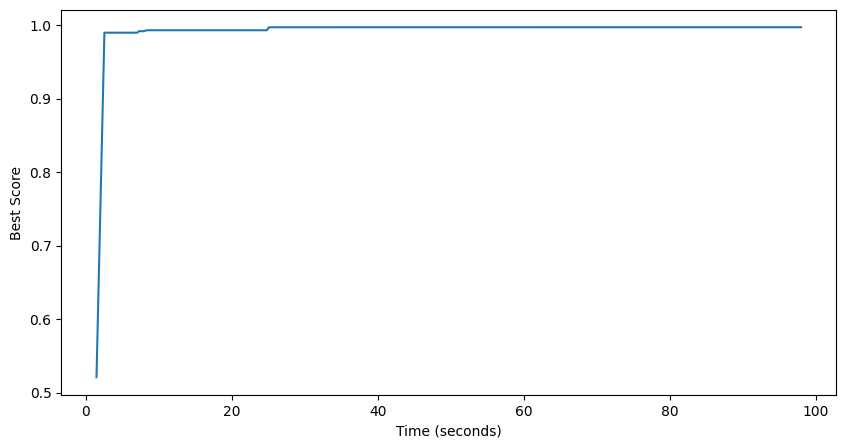

In [17]:
#get columns where roc_auc_score is not NaN
scores_and_times = df[df['roc_auc_score'].notna()][['roc_auc_score', 'Completed Timestamp']].sort_values('Completed Timestamp', ascending=True).to_numpy()

#get best score at a given time
best_scores = np.maximum.accumulate(scores_and_times[:,0])
times = scores_and_times[:,1]
times = times - df['Submitted Timestamp'].min()

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(times, best_scores)
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Best Score')
plt.show()


# Checkpointing

There are two ways to resume TPOT. 
* If the `warm_start` parameter is set to True, subsequent calls to `fit` will continue training where it left off (The conventional scikit-learn default is to retrain from scratch on subsequent calls to fit). 
* If `periodic_checkpoint_folder` is set, TPOT will periodically save its current state to disk. If TPOT is interrupted (job canceled, PC shut off, crashes), you can resume training from where it left off. The checkpoint folder stores a data frame of all evaluated pipelines. This data frame can be loaded and inspected to help diagnose problems when debugging.


**Note: TPOT does not clean up the checkpoint files. If the `periodic_checkpoint_folder` parameter is set, training from the last saved point will always continue, even if the input data has changed. A common issue is forgetting to change this folder between experiments and TPOT continuing training from pipelines optimized for another dataset. If you intend to start a run from scratch, you must either remove the parameter, supply an empty folder, or delete the original checkpoint folder.**

### Common parameters

Here is a subset of the most common parameters to customize and what they do. See the docs for `TPOTEstimator` or `TPOTEstimatorSteadyState` full documentation of all parameters. 

| Parameter                      | Type                  | Description                                                                 |
|--------------------------------|-----------------------|-----------------------------------------------------------------------------|
| scorers                        | list, scorer          | List of scorers for cross-validation; see                                    |
| scorers_weights                | list                  | Weights applied to scorers during optimization                              |
| classification                 | bool                  | Problem type: True for classification, False for regression                 |
| cv                             | int, cross-validator  | Cross-validation strategy: int for folds or custom cross-validator          |
| max_depth                      | int                   | Maximum pipeline depth                                                      |
| other_objective_functions      | list                  | Additional objective functions; default: [average_path_length_objective]    |
| other_objective_functions_weights | list              | Weights for additional objective functions; default: [-1]                   |
| objective_function_names       | list                  | Names for objective functions; default: None (uses function names)          |
| bigger_is_better               | bool                  | Optimization direction: True for maximize, False for minimize               |
| generations                    | int                   | Number of optimization generations; default: 50                             |
| max_time_mins                  | float                 | Maximum optimization time (minutes); default: infinite                      |
| max_eval_time_mins             | float                 | Maximum evaluation time per individual (minutes); default: 300              |
| n_jobs                         | int                   | Number of parallel processes; default: 1                                    |
| memory_limit                   | str                   | Memory limit per job; default: "4GB"                                        |
| verbose                        | int                   | Optimization process verbosity: 0 (none), 1 (progress), 3 (best individual), 4 (warnings), 5+ (full warnings) |
| memory                         | str, memory object    | If supplied, pipeline will cache each transformer after calling fit with joblib.Memory. |
| periodic_checkpoint_folder     | str                   | Folder to save the population to periodically. If None, no periodic saving will be done. If provided, training will resume from this checkpoint.|
        


# Preventing Overfitting

On small datasets, it is not impossible for TPOT to overfit the cross-validation score itself. This can lead to lower-than-expected performance on held-out datasets. TPOT will always return the model with the highest CV score as its final fitted_pipeline. However, if the highest performing model, as evaluated by cross-validation, actually was just overfit to the CV score, it may actually be worse performing compared to other models on the Pareto front.
  * Using a secondary complexity objective and evaluating the entire pareto front may be beneficial. In some cases a lower performing pipeline with lower complexity can actually perform better on held out sets. These can either be evaluated and compared on a held out validation set, or sometimes, if very data limited, simply using a different seed of splitting the CV folds can work as well.
    * TPOT can do this automatically. The `validation_strategy` parameter can be set to re-test the final pareto front on either a held-out validation set (percent of data set by `validation_fraction`) or a different seed for splitting the CV folds. These can be selected by setting `validation_strategy` to "split" or "reshuffled", respectively.
  * Increasing the number of folds of cross-validation can mitigate this. 
  * Nested cross-validation can also be used to estimate the performance of the TPOT optimization algorithm itself.
  * Removing more complex methods from the search space can reduce the chances of overfitting

# Tips and tricks for speeding up TPOT

TPOT can be a computationally demanding algorithm as it fits thousands of complex machine learning pipelines on potentially large datasets. There are several strategies available for improving run time by reducing the compute needed. 

There are three main strategies implemented in TPOT to reduce redundant work and/or prevent wasting compute on poorly performing pipelines.

1. TPOT pipelines will often have the exact same components doing the exact same computation (e.g. the first steps of the pipeline remain the same and only the parameters of the final classifier changed.) In these cases, that The first strategy is to simply cache these repeat computations so that they only happen once. More info in the next subsection.
2. Successive Halving. This idea was first tested with TPOT by Parmentier et al. in ["TPOT-SH: a Faster Optimization Algorithm to Solve the AutoML Problem on Large Datasets"](https://www.researchgate.net/profile/Laurent-Parmentier-4/publication/339263193_TPOT-SH_A_Faster_Optimization_Algorithm_to_Solve_the_AutoML_Problem_on_Large_Datasets/links/5e5fd8b8a6fdccbeba1c6a56/TPOT-SH-A-Faster-Optimization-Algorithm-to-Solve-the-AutoML-Problem-on-Large-Datasets.pdf). The algorithm operates in two stages. Initially, it trains early generations using a small data subset and a large population size. Later generations then evaluate a smaller set of promising pipelines on larger, or even full, data portions. This approach rapidly identifies top-performing pipeline configurations through initial rough evaluations, followed by more comprehensive assessments. More information on this strategy in Tutorial 8.
3. Most often, we will be evaluating pipelines using cross validation. However, we can often tell within the first few folds whether or not the pipeline is going have a reasonable change of outperforming the previous best pipelines. For example, if the best score so far is .92 AUROC and the average score of the first five folds of our current pipeline is only around .61, we can be reasonably confident that the next five folds are unlikely to this pipeline ahead of the others. We can save a significant amount of compute by not computing the rest of the folds. There are two strategies that TPOT can use to accomplish this (More information on these strategies in Tutorial 8).
   1. Threshold Pruning: Pipelines must achieve a score above a predefined percentile threshold (based on previous pipeline scores) to proceed in each cross-validation (CV) fold.
   2. Selection Pruning: Within each population, only the top N% of pipelines (ranked by performance in the previous CV fold) are selected to evaluate in the next fold."
    

## Pipeline caching in TPOT (joblib.Memory)

With the memory parameter, pipelines can cache the results of each transformer after fitting them. This feature is used to avoid repeated computation by transformers within a pipeline if the parameters and input data are identical to another fitted pipeline during the optimization process. TPOT allows users to specify a custom directory path or joblib.Memory in case they want to re-use the memory cache in future TPOT runs (or a warm_start run).

There are three methods for enabling memory caching in TPOT:

In [19]:
from tpot import TPOTClassifier
from tempfile import mkdtemp
from joblib import Memory
from shutil import rmtree

# Method 1, auto mode: TPOT uses memory caching with a temporary directory and cleans it up upon shutdown
est = TPOTClassifier(memory='auto')

# Method 2, with a custom directory for memory caching
est = TPOTClassifier(memory='/to/your/path')

# Method 3, with a Memory object
memory = Memory(location='./to/your/path', verbose=0)
est = TPOTClassifier(memory=memory)


**Note: TPOT does NOT clean up memory caches if users set a custom directory path or Memory object. We recommend that you clean up the memory caches when you don't need it anymore.**

## 



# Advanced Parallelization (HPC and multi-node training)

See Tutorial 7 for more details on parallelization with Dask, including information of using multiple nodes.

# FAQ and Debugging

If you are experiencing issues with TPOT, here are some common issues and how to address them.

* Performance is lower than expected. What can I do?
  * TPOT may have to be run for a longer duration, increase `max_time_mins`, `early_stop`, or `generations`.
  * Individual pipelines may need more time to complete fitting; increase `max_eval_time_seconds.`
  * The configuration may not include the optimal model types or hyperparameter ranges, explore other included templates, or customize your own search space (see Tutorial 2!)
  * Check that `periodic_checkpoint_folder` is set correctly. A common issue is forgetting to change this folder between experiments and TPOT continuing training from pipelines optimized for another dataset.
* TPOT is too slow! It is running forever and never terminating
  * Check that at least one of the three termination conditions is set to a reasonable level. These are `max_time_mins`, `early_stop`, or `generations`. Additionally, check that `max_eval_time_seconds` gives enough time for most models to train without being overly long. (Some estimators may take an unreasonably long time to fit; this parameter is intended to prevent them from slowing everything to a halt. In my experience, SVC and SVR tend to be the culprits, so removing them from the search space may also improve run time).
  * Set the `memory` parameter to allow TPOT to prevent repeated work when using either scikit-learn pipelines or TPOT GraphPipelines.
  * Increase n_jobs to use more processes/CPU power. See Tutorial 7 for advanced Dask usage, including parallelizing across multiple nodes on an HPC.
  * Use feature selection, either the build in configuration of sklearn methods (see Tutorial 2), or genetic feature selection (see Tutorials 3 and 5 for two different strategies).
  * Use successive halving to reduce computational load (See tutorial 8).
* Many pipelines in the evaluated_individuals data frame have crashed or turned up invalid!
  * This is normal and is expected behavior for TPOT. In some cases, TPOT may attempt an invalid hyperparameter combination, resulting in the pipeline not working. Other times, the pipeline configuration itself may be invalid. For example, a selector may not select any features due to its hyperparameter. Another common example is `MultinomialNB` throwing an error because it expects positive values, but a prior transformation yielded a negative value. 
  * If you used custom search spaces, you can use `ConfigSpace` conditionals to prevent invalid hyperparameters (this may still occur due to how TPOT uses crossover).
  * Setting `verbose=5` will print out the full error message for all failed pipelines. This can be useful for debugging whether or not there is something misconfigured in your pipeline, custom search space modules, or something else.
* TPOT is crashing due to memory issues
  * Set the `memory_limit` parameter so that n_jobs*memorylimit is less than the available RAM on your machine, plus some wiggle room. This should prevent crashing due to memory concerns.
  * Using feature selection may also improve memory usage, as described above.
  * Remove modules that create high RAM usage (e.g. multiple PolynomialFeatures or one with high degree).
* Why are my TPOT runs not reproducible when random_state is set?
  * Check that `periodic_checkpoint_folder` is set correctly. If this is set to a non-empty folder, TPOT will continue training from the checkpoint rather than start a new run from scratch. For TPOT runs to be reproducible, they have to have the same starting points.
  * If using custom search spaces, pass in a fixed `random_state` value into the configspace of the scikit-learn modules that utilize them. TPOT does not check whether estimators do or do not take in a random state value (See Tutorial 2).
  * If using the pre-built search spaces provided by TPOT, make sure to pass in `random_state` to `tpot.config.get_configspace` or `tpot.config.template_search_spaces.get_template_search_spaces`. This ensures all estimators that support it get a fixed random_state value. (See Tutorial 2).
  * If using custom Node and Pipeline types, ensure all random decisions utilize the rng parameter passed into the mutation/crossover functions.
  * If `max_eval_time_mins` is set, TPOT will terminate pipelines that exceed this time limit. If the pipeline evaluation happens to be very similar to the time limit, small random fluctuations in CPU allocation may cause a given pipeline to be evaluated in one run but not another. This slightly different result would throw off the random number generator throughout the rest of the run. Setting `max_eval_time_mins` to None or a higher value may prevent this edge case.
  * If using `TPOTEstimatorSteadyState` with `n_jobs`>1, it is also possible that random fluctuations in CPU allocation slightly change the order in which pipelines are evaluated, which will affect the downstream results. `TPOTEstimatorSteadyState` is more reliably reproducible when `n_jobs=1` (This is not an issue for the default `TPOTEstimator`, `TPOTClassifier`, `TPOTRegressor` as they used a batched generational approach where execution order does not impact results).
* TPOT is not using all the CPU cores I expected, given my `n_jobs` setting.
  * The default TPOT algorithm uses a generational approach. This means the TPOT will need to evaluate `population_size` (default 50) pipelines before starting the next batch. At the end of each generation, TPOT may leave threads unused while it waits for the last few pipelines to finish evaluating. Some estimators or pipelines can be significantly slower to evaluate than others. This can be addressed in a few ways:
    * Decrease `max_eval_time_mins` to cut long-running pipeline evaluations early.
    * Remove estimators or hyperparameter configurations that are prone to very slow convergence (which is very often `SVC` or `SVR`).
    * Alternatively, `TPOTEstimatorSteadyState` uses a slightly different backend for the evolutionary algorithm that does not utilize the generational approach. Instead, new pipelines are generated and evaluated as soon as the previous one finishes. With this estimator, all cores should be utilized at all times. 
    * Sometimes, setting n_jobs to a multiple of the number of threads can help minimize the chances of threads being idle while waiting for others to finish

# More Options

`tpot.TPOTClassifier` and `tpot.TPOTRegressor` have a simplified set of hyperparameters with default values set for classification and regression problems. Currently, both of these use the standard evolutionary algorithm in the `tpot.TPOTEstimator` class. If you want more control, you can look into either the `tpot.TPOTEstimator` or `tpot.TPOTEstimatorSteadyState` class.

There are two evolutionary algorithms built into TPOT, which corresponds to two different estimator classes.

1. The `tpot.TPOTEstimator` uses a standard evolutionary algorithm that evaluates exactly population_size individuals each generation. This is similar to the algorithm in TPOT1. The next generation does not start until the previous is completely finished evaluating. This leads to underutilized CPU time as the cores are waiting for the last individuals to finish training, but may preserve diversity in the population. 

2. The `tpot.TPOTEstimatorSteadyState` differs in that it will generate and evaluate the next individual as soon as an individual finishes the evaluation. The number of individuals being evaluated is determined by the n_jobs parameter. There is no longer a concept of generations. The population_size parameter now refers to the size of the list of evaluated parents. When an individual is evaluated, the selection method updates the list of parents. This allows more efficient utilization when using multiple cores.


### tpot.TPOTEstimatorSteadyState

In [18]:
import tpot
import sklearn
import sklearn.datasets


graph_search_space = tpot.search_spaces.pipelines.GraphSearchPipeline(
    root_search_space= tpot.config.get_search_space(["KNeighborsClassifier", "LogisticRegression", "DecisionTreeClassifier"]),
    leaf_search_space = tpot.config.get_search_space("selectors"), 
    inner_search_space = tpot.config.get_search_space(["transformers"]),
    max_size = 10,
)

est = tpot.TPOTEstimatorSteadyState( 
                            search_space = graph_search_space,
                            scorers=['roc_auc_ovr',tpot.objectives.complexity_scorer],
                            scorers_weights=[1,-1],


                            classification=True,

                            max_eval_time_mins=15,
                            max_time_mins=30,
                            early_stop=10, #In TPOTEstimatorSteadyState, since there are no generations, early_stop is the number of pipelines to evaluate before stopping.
                            n_jobs=30,
                            verbose=2)


scorer = sklearn.metrics.get_scorer('roc_auc_ovo')
X, y = sklearn.datasets.load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.75, test_size=0.25)
est.fit(X_train, y_train)
print(scorer(est, X_test, y_test))

Evaluations: : 134it [01:00,  2.22it/s]
/Users/matsumoton/miniconda3/envs/tpot2_310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.99812734082397


In [ ]:
fitted_pipeline = est.fitted_pipeline_ # access best pipeline directly
fitted_pipeline.plot()

In [ ]:
#view the summary of all evaluated individuals as a pandas dataframe
est.evaluated_individuals.head()

### tpot.TPOTEstimator

In [ ]:
import tpot
import sklearn
import sklearn.datasets

est = tpot.TPOTEstimator(  
                            search_space = graph_search_space,
                            max_time_mins=10,
                            scorers=['roc_auc_ovr'], #scorers can be a list of strings or a list of scorers. These get evaluated during cross validation. 
                            scorers_weights=[1],
                            classification=True,
                            n_jobs=1, 
                            early_stop=5, #how many generations with no improvement to stop after
                            
                            #List of other objective functions. All objective functions take in an untrained GraphPipeline and return a score or a list of scores
                            other_objective_functions= [ ],
                            
                            #List of weights for the other objective functions. Must be the same length as other_objective_functions. By default, bigger is better is set to True. 
                            other_objective_functions_weights=[],
                            verbose=2)

scorer = sklearn.metrics.get_scorer('roc_auc_ovo')
X, y = sklearn.datasets.load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.75, test_size=0.25)
est.fit(X_train, y_train)
print(scorer(est, X_test, y_test))

Regression Example

In [ ]:
import tpot
import sklearn
import sklearn.metrics
import sklearn.datasets

scorer = sklearn.metrics.get_scorer('neg_mean_squared_error')
X, y = sklearn.datasets.load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.75, test_size=0.25)

est = tpot.tpot_estimator.templates.TPOTRegressor(n_jobs=4, max_time_mins=30, verbose=2, cv=5, early_stop=5)
est.fit(X_train, y_train)

print(scorer(est, X_test, y_test))